<center>
    <h2>predicting house price in tehran</h2>
    <h3> by soroush lotfi</h3>
</center>

# Table of content:
1. [Import Libraries](#1)
2. [Reading Dataset](#2)
3. [Data Pre-processing](#3)

 - <a href='#duplicate'>step1: Deduplicating the data</a>
 - <a href='#structure'>step2: Fixing structural errors</a>
 - <a href='#missingData'>step3: Dealing with missing data</a>
 - <a href='#outliers'>step4: Filtering data outliers</a>
 - <a href='#categorical'> step5: Converting categorical variables into dummy variables</a>
<br>
<br>
4. [Modeling](#4)
5. [Conclusions](#5)
6. [References](#6)

# Import Libraries <a id = "1"></a> 

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import  ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor

import seaborn as sns
sns.set_style("whitegrid")

import time

import warnings
warnings.filterwarnings("ignore")

# Reading Dataset <a id = "2"></a> 



|parameter||description|
|------||------|
|Area||Area in square meters|
|Room||Number of bedrooms|
|Parking|| Has Parking or not|
|Warehouse||Has warehouse or not|
|Elevator||Has elevator or not|
|Address|| The region where the house is placed|
|Price||Price in Toman|
|Price(USD)|| Price in USD|

In [44]:
house_price = pd.read_csv('housePrice.csv')
print("shape of the dataset:",house_price.shape)
house_price.head()

shape of the dataset: (3479, 8)


,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


# Data Pre-processing <a id = "3"></a> 

In [45]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB


### step1: Deduplicate your data.  <a id='duplicate'></a> <br />

In [46]:
temp=house_price.groupby(house_price.columns.tolist(),as_index=False).size()
temp.head()

#size column in temp represents how many times each row showes up in dataset

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),size
0,"1,000",2,True,True,False,Damavand,7.000000e+09,233333.33,1
1,"16,160,000,000",3,True,True,True,Pasdaran,1.616000e+10,538666.67,1
2,"2,550,000,000",2,True,True,True,Central Janatabad,2.550000e+09,85000.00,1
3,"3,310,000,000",2,True,True,True,Ostad Moein,3.310000e+09,110333.33,1
4,"3,600",2,False,False,False,Shahryar,9.720000e+09,324000.00,1


In [47]:
temp['size'].value_counts()

1     3087
2      131
3       24
4        4
5        1
14       1
Name: size, dtype: int64

In [48]:
#we need to remove all the data that accured in our dataset more than 1 time

house_price.drop_duplicates(inplace = True)
house_price.reset_index(drop = True, inplace= True)

print(f"Shape of dataset after removing duplicate rows: {house_price.shape}")
house_price.head()

Shape of dataset after removing duplicate rows: (3271, 8)


,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


### step2: Fix structural errors.  <a id='structure'></a> <br />

In [49]:
#changing object type of "Area" to a numeric type
house_price['Area'] = pd.to_numeric(house_price['Area'], errors='coerce')

#changing boolean types of 'Parking','Warehouse','Elevator' to integer

boolean_features = ['Parking','Warehouse','Elevator']
house_price[boolean_features] = house_price[boolean_features].astype('int64')

#deleting 'Price' column
house_price = house_price.drop(columns = ['Price'])
# house_price = house_price.drop(columns = ['Price(USD)'])

house_price.reset_index(drop = True, inplace= True)
house_price.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price(USD)
0,63.0,1,1,1,1,Shahran,61666.67
1,60.0,1,1,1,1,Shahran,61666.67
2,79.0,2,1,1,1,Pardis,18333.33
3,95.0,2,1,1,1,Shahrake Qods,30083.33
4,123.0,2,1,1,1,Shahrake Gharb,233333.33


### step3: Deal with missing data. <a id='missingData'></a> <br />

In [50]:
house_price.isnull().sum()

Area           6
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price(USD)     0
dtype: int64

In [51]:
house_price.dropna(inplace=True)
house_price.reset_index(drop = True, inplace= True)

print(f"Shape of dataset after removing NA values: {house_price.shape}")

Shape of dataset after removing NA values: (3242, 7)


In [52]:
house_price.isnull().sum()

Area          0
Room          0
Parking       0
Warehouse     0
Elevator      0
Address       0
Price(USD)    0
dtype: int64

### step4: Filter out data outliers.  <a id='outliers'></a> <br />

our dataset must follow a normal (or Gaussian) distribution.for that, the skewness value of dataset's variables should be between -1 and +1, and any major deviation from this range indicates the presence of extreme values.

In [53]:
print(f"Skewness of features:\n{house_price.skew()}")

Skewness of features:
Area          4.458299
Room          0.639516
Parking      -1.909123
Warehouse    -2.960367
Elevator     -1.392628
Price(USD)    4.729404
dtype: float64


<AxesSubplot:xlabel='Price(USD)'>

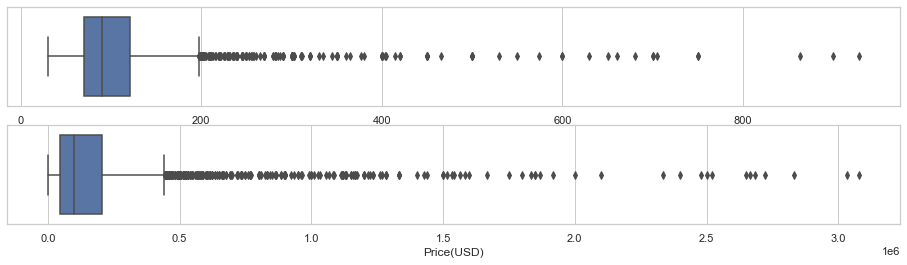

In [54]:
plt.figure(figsize = (16,4))

plt.subplot(2,1,1)
sns.boxplot(x = house_price['Area'])

plt.subplot(2,1,2)
sns.boxplot(x = house_price['Price(USD)'])



In [55]:
def lower_upper(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    return lower, upper

lower_area, upper_area = lower_upper(house_price['Area'])
lower_price, upper_price = lower_upper(house_price['Price(USD)'])

print(f"Lower limit for area: {lower_area:0.2f}")
print(f"Upper limit for area: {upper_area:0.2f}")
print(f"Lower limit for price: {lower_price:,}")
print(f"Upper limit for price: {upper_price:,}")

Lower limit for area: -6.50
Upper limit for area: 197.50
Lower limit for price: -189,541.67124999996
Upper limit for price: 442,124.99874999997


In [56]:
area_outliers = np.where(house_price['Area'] > upper_area)
price_outliers = np.where(house_price['Price(USD)'] > upper_price)
total_outliers = np.union1d(area_outliers, price_outliers)

print(f"Number of area outliers: {len(house_price.iloc[area_outliers])}")
print(f"Number of price outliers: {len(house_price.iloc[price_outliers])}")
print(f"Number of total outliers: {len(house_price.iloc[total_outliers])}")

Number of area outliers: 229
Number of price outliers: 277
Number of total outliers: 332


In [57]:
house_price.drop(total_outliers, inplace = True)
house_price.reset_index(drop = True, inplace = True)
print(f"Shape of new dataset: {house_price.shape}")

Shape of new dataset: (2910, 7)


<AxesSubplot:xlabel='Price(USD)'>

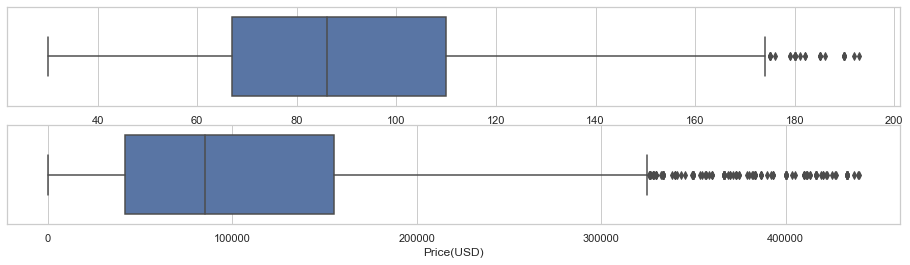

In [58]:
plt.figure(figsize = (16,4))

plt.subplot(2,1,1)
sns.boxplot(x = house_price['Area'])

plt.subplot(2,1,2)
sns.boxplot(x = house_price['Price(USD)'])



In [59]:
print(f"Skewness of features after drop outliers:\n{house_price.skew()}")

Skewness of features after drop outliers:
Area          0.674259
Room          0.171046
Parking      -1.779850
Warehouse    -2.895686
Elevator     -1.389789
Price(USD)    1.295932
dtype: float64


### step5: Convert categorical variable('Adress') into dummy variables. <a id='categorical'></a> <br />

In [18]:
addres_dummy = pd.get_dummies(house_price['Address'])
house_price = house_price.merge(addres_dummy, left_index = True, right_index = True)
house_price.drop(columns = 'Address', inplace = True)
house_price.head(3)

# from sklearn.preprocessing import LabelEncoder
# encode_address = LabelEncoder()
# house_price['Address'] = encode_address.fit_transform(house_price['Address'])
# house_price


,Area,Room,Parking,Warehouse,Elevator,Price(USD),Abazar,Abbasabad,Abuzar,Afsarieh,...,Waterfall,West Ferdows Boulevard,West Pars,Yaftabad,Yakhchiabad,Yousef Abad,Zafar,Zaferanieh,Zargandeh,Zibadasht
0,63.0,1,1,1,1,61666.67,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60.0,1,1,1,1,61666.67,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,79.0,2,1,1,1,18333.33,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modeling <a id = "4"></a> 

In [20]:
X = house_price.drop(columns = 'Price(USD)')
y = house_price['Price(USD)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
print(f"shape of x train: {X_train.shape}")
print(f"shape of y train: {y_train.shape}")
print(f"shape of x test: {X_test.shape}")
print(f"shape of y train: {y_test.shape}")

X=np.asanyarray(X)
y=np.asanyarray(y)


shape of x train: (2328, 192)
shape of y train: (2328,)
shape of x test: (582, 192)
shape of y train: (582,)


In [28]:
def parameter_finder (model, parameters):
    
    start = time.time()
    
    grid = GridSearchCV(model, 
                        param_grid = parameters, 
                        refit = "r2", 
                        cv = KFold(n_splits=5,shuffle = True, random_state = 10), 
                        n_jobs = -1)
    grid_fit = grid.fit(X_train, y_train)
    y_pred = grid_fit.predict(X_test)
    
    test_score = round(grid_fit.score(X_test, y_test), 4)
    RMSE = round(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    model_name = str(model).split('(')[0]
    
    end = time.time()
    
    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"The coefficient of determination (R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"RMSE is {RMSE:,} for {model_name} model.")
    print("--" * 10)
    print(f"Runtime of the program is: {end - start:0.2f}")
    
       
    return test_score, RMSE

### linear regression

In [29]:
lr = LinearRegression(n_jobs = -1)

lr_test_score, lr_RMSE = parameter_finder(lr, {'normalize':[True,False],
                                                              'fit_intercept':[True,False]})

The best parameters for LinearRegression model is: {'fit_intercept': False, 'normalize': True}
--------------------
The coefficient of determination (R2 score) in the testing set is -87446602050321874944.00% for LinearRegression model.
RMSE is 94,692,158,453,580 for LinearRegression model.
--------------------
Runtime of the program is: 0.41


the R2-score for linear regression is a negative number, which means The model fits the data very badly.
so we can immidiately rule it out from our options for modeling  

### ridge regression

In [60]:
ridge = Ridge(random_state = 1) # Linear least squares with l2 regularization.
param_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

ridge_test_score, ridge_RMSE = parameter_finder(ridge, param_ridge)

The best parameters for Ridge model is: {'alpha': 0.1}
--------------------
The coefficient of determination (R2 score) in the testing set is 85.43% for Ridge model.
RMSE is 38,651 for Ridge model.
--------------------
Runtime of the program is: 2.91


### lasso regression

In [32]:
lasso = Lasso(random_state = 1) # Linear Model trained with L1 prior as regularizer.
param_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

lasso_test_score, lasso_RMSE = parameter_finder(lasso, param_lasso)

The best parameters for Lasso model is: {'alpha': 10}
--------------------
The coefficient of determination (R2 score) in the testing set is 85.50% for Lasso model.
RMSE is 38,562 for Lasso model.
--------------------
Runtime of the program is: 4.21


### elasticNet

In [34]:
eln = ElasticNet(random_state = 1) # Linear regression with combined L1 and L2 priors as regularizer.
param_eln = {'alpha': [0.001, 0.01, 0.1, 1, 10],
            'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7]}

eln_test_score, eln_RMSE = parameter_finder(eln, param_eln)

The best parameters for ElasticNet model is: {'alpha': 0.001, 'l1_ratio': 0.7}
--------------------
The coefficient of determination (R2 score) in the testing set is 85.41% for ElasticNet model.
RMSE is 38,679 for ElasticNet model.
--------------------
Runtime of the program is: 2.08


### decisionTree regressor

In [35]:
dtr = DecisionTreeRegressor(random_state = 1)
param_dtr = {'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3]}

dtr_test_score, dtr_RMSE = parameter_finder(dtr, param_dtr)

The best parameters for DecisionTreeRegressor model is: {'min_samples_leaf': 1, 'min_samples_split': 4}
--------------------
The coefficient of determination (R2 score) in the testing set is 78.90% for DecisionTreeRegressor model.
RMSE is 46,514 for DecisionTreeRegressor model.
--------------------
Runtime of the program is: 0.64


### randomForest regressor

In [36]:
rfr = RandomForestRegressor(random_state = 1, n_jobs = -1)
param_rfr = {'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3]}

rfr_test_score, rfr_RMSE = parameter_finder(rfr, param_rfr)

The best parameters for RandomForestRegressor model is: {'min_samples_leaf': 1, 'min_samples_split': 5}
--------------------
The coefficient of determination (R2 score) in the testing set is 83.21% for RandomForestRegressor model.
RMSE is 41,495 for RandomForestRegressor model.
--------------------
Runtime of the program is: 13.82


### KNeighbor regressor

In [37]:
knr = KNeighborsRegressor(n_jobs = -1)
param_knr = {'n_neighbors': [5, 10, 15, 20],
            'weights': ['uniform', 'distance']}

knr_test_score, knr_RMSE = parameter_finder(knr, param_knr)

The best parameters for KNeighborsRegressor model is: {'n_neighbors': 15, 'weights': 'distance'}
--------------------
The coefficient of determination (R2 score) in the testing set is 62.42% for KNeighborsRegressor model.
RMSE is 62,073 for KNeighborsRegressor model.
--------------------
Runtime of the program is: 1.08


# Conclusions <a id = "5"></a> 

In [61]:
models_score = pd.DataFrame({'Testing score': [
                                 ridge_test_score, 
                                                lasso_test_score, eln_test_score,
                                               dtr_test_score, rfr_test_score,
                                               knr_test_score],
                             'RMSE': [
                                 ridge_RMSE,
                                      lasso_RMSE, eln_RMSE,
                                      dtr_RMSE, rfr_RMSE,
                                      knr_RMSE],                             
                             },
                           index = [
                               'Ridge', 'Lasso','ElasticNet',
                                    'DecisionTreeRegressor', 'RandomForestRegressor',
                                    'KNeighborsRegressor']
                           )

models_score

,Testing score,RMSE
Ridge,0.8543,38651
Lasso,0.8550,38562
ElasticNet,0.8541,38679
DecisionTreeRegressor,0.7890,46514
RandomForestRegressor,0.8321,41495
KNeighborsRegressor,0.6242,62073


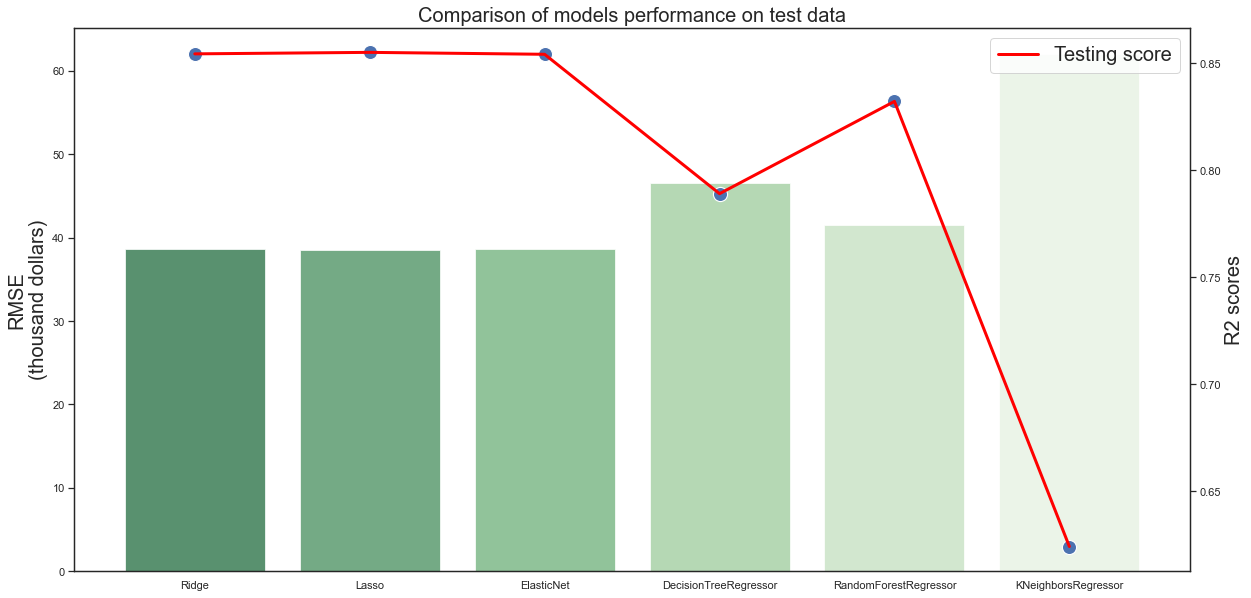

In [65]:
fig, ax = plt.subplots(figsize=(20,10))

sns.set(style='white')

ax.set_title("Comparison of models performance on test data", fontsize = 20)

ax = sns.barplot(x = list(models_score.index), y = models_score['RMSE']/1e3, 
                 alpha = 0.7, palette='Greens_r')

ax.set_ylabel("RMSE\n(thousand dollars)", fontsize = 20)

sec_ax = ax.twinx()

sec_ax = sns.lineplot(x = list(models_score.index), y = models_score['Testing score'],
                 linewidth = 3, color = 'red')
sec_ax = sns.scatterplot(x = list(models_score.index), y = models_score['Testing score'],
                    s = 200)

sec_ax.set_ylabel("R2 scores", fontsize = 20)

sec_ax.legend(labels = [
    'Testing score'], fontsize = 20,loc='best')

plt.show()

#### in conclusion, the best methods for our modelling would be "Ridge,lasso and ElasticNet" (all three of them almost have the same performance)